In [2]:
import numpy as np
from FlagRep import FlagRep
from matplotlib import pyplot as plt
from FlagRep0 import chordal_distance

import pandas as pd

import seaborn as sns

from sklearn.metrics.pairwise import paired_cosine_distances, paired_euclidean_distances


In [3]:
n_pts = 60
n_clusters = 3

n = 10
col_ids = [20,20]
p = np.sum(col_ids)
hidden_flag_type = [2,4]
hidden_ms = [2,2]
noise_exps = range(1,1000,50)
distributions = ['Normal', 'Exponential', 'Uniform']

In [4]:
rows = n
centers = []
for _ in range(n_clusters):
    center = []
    ProjMat = np.eye(rows)
    for i in range(len(hidden_flag_type)):            
        rank = hidden_ms[i] # Specify the desired rank
        rand_mat = np.random.randn(rows, rank)
        hidden_X = ProjMat @ np.linalg.qr(rand_mat)[0][:,:rank]
        ProjMat = np.eye(rows) - hidden_X @ hidden_X.T
        center.append(hidden_X)
    centers.append(center)


In [25]:
Ds = []
labels = []
for class_num, center in enumerate(centers):
    for _ in range(n_pts//n_clusters):
        D = []
        for i in range(len(hidden_flag_type)): 
            cols = col_ids[i]
            rank = hidden_ms[i]
            low_rank_matrix = np.linalg.qr(center[i]+np.random.normal(scale = .3, size=(rows,rank)))[0][:,:rank]
            D.append(low_rank_matrix@np.random.normal(size= (rank, cols)))
        D = np.hstack(D)
        Ds.append(D)
        labels.append(class_num)

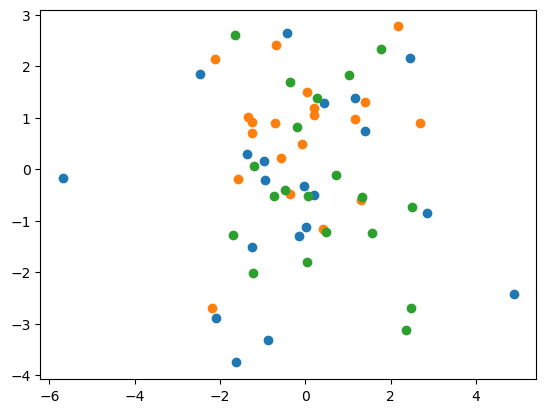

In [26]:
# pca
from sklearn.decomposition import PCA

Ds_flat = np.vstack([D.flatten() for D in Ds])
my_pca = PCA(n_components = 2)
Ds_flat_pca = my_pca.fit_transform(Ds_flat)
plt.scatter(Ds_flat_pca[:20,0], Ds_flat_pca[:20,1])
plt.scatter(Ds_flat_pca[20:40,0], Ds_flat_pca[20:40,1])
plt.scatter(Ds_flat_pca[40:,0], Ds_flat_pca[40:,1])

In [31]:
flags = []
for D in Ds:
    my_flag_rep = FlagRep(Aset = [np.arange(col_ids[0]),np.arange(p)], solver = 'svd', flag_type=[2,4])
    X = my_flag_rep.fit_transform(D)
    # X = np.linalg.svd(D)[0][:,:4]
    flags.append(X)

In [35]:
def make_Bs(fl_type):
    Bs = [np.arange(fl_type[0])]
    for i in range(1,len(fl_type)):
        Bs.append(np.arange(fl_type[i-1],fl_type[i]))
    return Bs

Bs = make_Bs(hidden_flag_type)

dist_mat = np.zeros((n_pts,n_pts))
for i in range(n_pts):
    for j in range(i+1,n_pts):
        x = flags[i]
        y = flags[j]
        dist = chordal_distance(x, y, Bs, Bs)
        dist_mat[i,j] = dist
        dist_mat[j,i] = dist

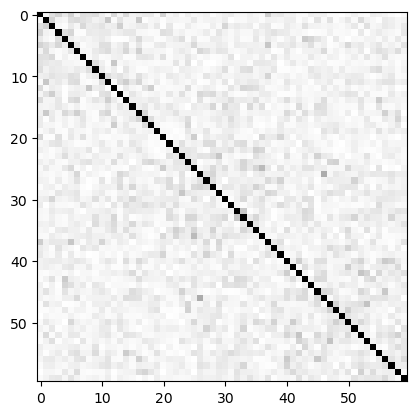

In [36]:
plt.imshow(dist_mat, cmap = 'grey')

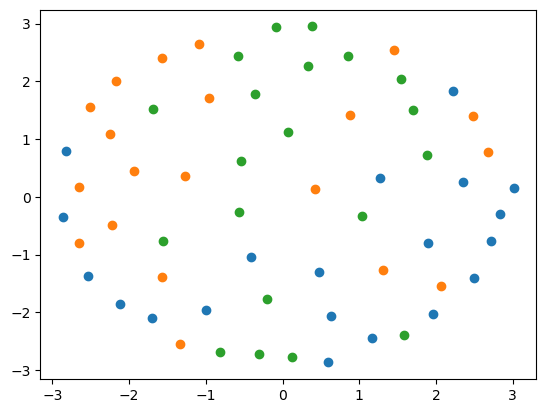

In [37]:
from sklearn.manifold import MDS

my_mds = MDS(dissimilarity = 'precomputed')
reduced_flags = my_mds.fit_transform(dist_mat)

plt.scatter(reduced_flags[:20,0], reduced_flags[:20,1])
plt.scatter(reduced_flags[20:40,0], reduced_flags[20:40,1])
plt.scatter(reduced_flags[40:,0], reduced_flags[40:,1])